# 🌦️ Prediksi Cuaca Australia dengan XGBoost & SHAP (Sederhana & Modular)

Notebook ini menyajikan pipeline prediksi hujan besok di Australia menggunakan XGBoost, GridSearchCV, dan SHAP. Fokus pada akurasi, workflow yang mudah diikuti, dan penjelasan fitur penting. Semua langkah dibuat modular dan output hanya yang esensial.

## 🚀 Workflow Prediksi Cuaca dengan XGBoost & SHAP (5-Fold Cross Validation)

1. **Instalasi & Import Library**
2. **Load Data**
3. **Analisis & Visualisasi Data Awal**
4. **Exploratory Data Analysis (EDA)**
5. **Analisis Missing Values**
6. **Data Preprocessing**
7. **Train-Test Split**
8. **Feature Engineering & Scaling**
9. **Penjelasan & Visualisasi Cross-Validation**
10. **Baseline Modeling dengan XGBoost + 5-Fold CV**
11. **Hyperparameter Tuning (GridSearchCV)**
12. **Evaluasi Model (Baseline vs Tuned)**
13. **Analisis & Visualisasi Lanjutan (Learning Curve, ROC, PR)**
14. **Improvement: Ensemble Stacking & Advanced Tuning**
15. **Perbandingan & Pemilihan Model Terbaik**
16. **Analisis Error & Interpretasi Model (SHAP)**
17. **Prediksi Manual & Validasi**

Setiap langkah akan dijelaskan dan diimplementasikan secara modular, dengan visualisasi dan output yang fokus pada insight penting.

## 1. Instalasi & Import Library

Langkah pertama adalah menginstal dan mengimpor semua library yang dibutuhkan.

In [1]:
# Install library yang dibutuhkan (jalankan hanya jika perlu)
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost shap --quiet

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
import shap
import os
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

## 2. Load Data

Load dataset utama dan tampilkan ringkasan awal.

In [2]:
# Load dataset utama
df = pd.read_csv('./dataset/Weather Training Data.csv')
print(f"Shape data: {df.shape}")
display(df.head())
print(f"Kolom: {list(df.columns)}")
print(f"Target tersedia: {'RainTomorrow' in df.columns}")
print(f"Total missing values: {df.isnull().sum().sum()}")

Shape data: (99516, 23)


,row ID,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,Row0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0
1,Row1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0
2,Row2,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0
3,Row3,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,...,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,0
4,Row4,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,...,48.0,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5,No,0


Kolom: ['row ID', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow']
Target tersedia: True
Total missing values: 221219


## 3. Analisis & Visualisasi Data

Analisis awal: distribusi target, missing values, dan ringkasan fitur numerik/kategorikal.

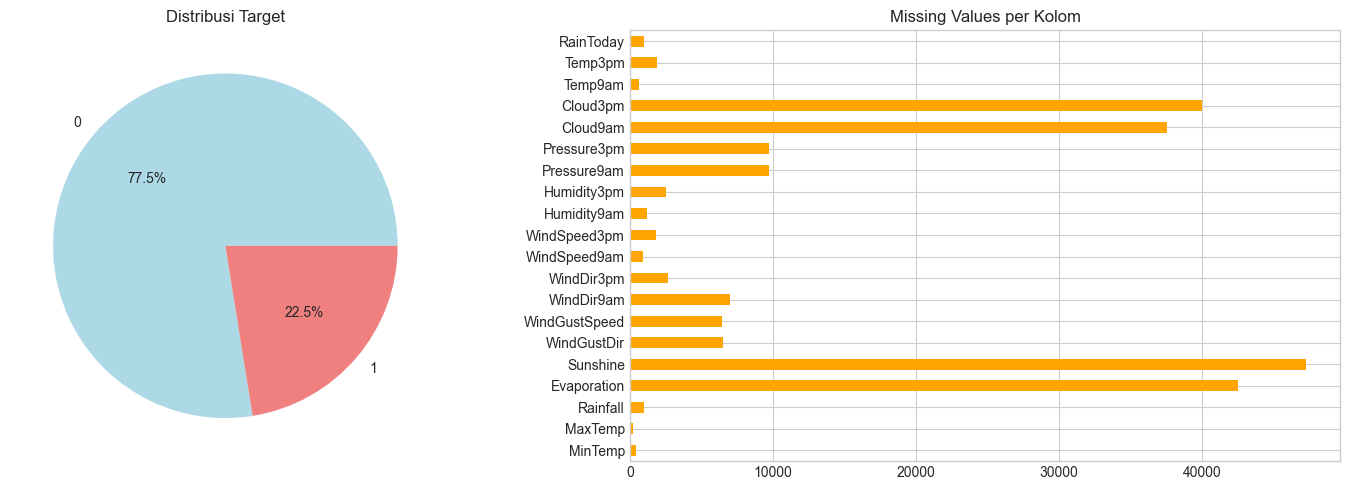

Numerical features: 17
Categorical features: 6


In [3]:
# Analisis distribusi target dan missing values
target_col = 'RainTomorrow' if 'RainTomorrow' in df.columns else 'RainToday'
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
df[target_col].value_counts().plot.pie(autopct='%1.1f%%', colors=['lightblue','lightcoral'])
plt.title('Distribusi Target')
plt.ylabel('')
plt.subplot(1,2,2)
missing = df.isnull().sum()
missing = missing[missing>0]
if not missing.empty:
    missing.plot.barh(color='orange')
    plt.title('Missing Values per Kolom')
else:
    plt.text(0.5,0.5,'Tidak ada missing values',ha='center',va='center',fontsize=14)
    plt.title('Missing Values')
plt.tight_layout()
plt.show()
print(f"Numerical features: {len(df.select_dtypes(include=[np.number]).columns)}")
print(f"Categorical features: {len(df.select_dtypes(include=['object']).columns)}")

## 4. Exploratory Data Analysis (EDA)

Visualisasi fitur utama, korelasi dengan target, dan ringkasan statistik.

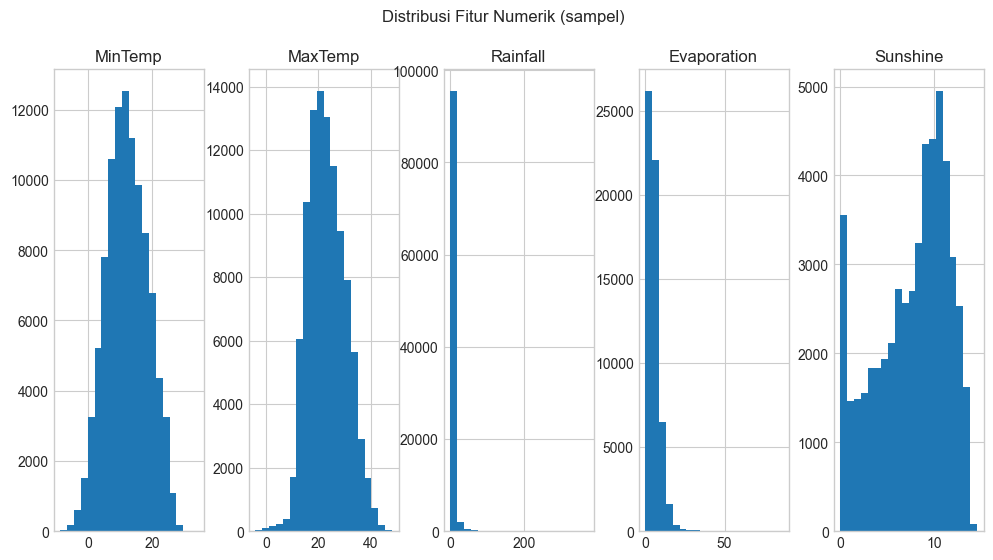

Korelasi fitur numerik dengan target:
Rainfall       0.238673
MinTemp        0.084531
Evaporation   -0.115249
MaxTemp       -0.159600
Sunshine      -0.448849
dtype: float64

Statistik deskriptif:


,count,mean,std,min,25%,50%,75%,max
MinTemp,99073.0,12.176266,6.390882,-8.5,7.6,12.0,16.8,33.9
MaxTemp,99286.0,23.218513,7.115072,-4.1,17.9,22.6,28.2,48.1
Rainfall,98537.0,2.353024,8.487866,0.0,0.0,0.0,0.8,371.0
Evaporation,56985.0,5.461320,4.162490,0.0,2.6,4.8,7.4,86.2
Sunshine,52199.0,7.615090,3.783008,0.0,4.8,8.4,10.6,14.5
WindGustSpeed,93036.0,39.976966,13.581524,6.0,31.0,39.0,48.0,135.0
WindSpeed9am,98581.0,14.004849,8.902323,0.0,7.0,13.0,19.0,130.0
WindSpeed3pm,97681.0,18.650464,8.801827,0.0,13.0,19.0,24.0,87.0
Humidity9am,98283.0,68.866376,19.074951,0.0,57.0,70.0,83.0,100.0
Humidity3pm,97010.0,51.433296,20.777616,0.0,37.0,52.0,65.0,100.0


In [4]:
# Visualisasi fitur utama dan korelasi dengan target
num_cols = df.select_dtypes(include=[np.number]).columns[:5]
df[num_cols].hist(figsize=(12,6), bins=20, layout=(1,len(num_cols)))
plt.suptitle('Distribusi Fitur Numerik (sampel)')
plt.show()
print('Korelasi fitur numerik dengan target:')
if df[target_col].dtype == 'object':
    target_num = df[target_col].map({'No':0,'Yes':1})
else:
    target_num = df[target_col]
corrs = df[num_cols].corrwith(target_num).sort_values(ascending=False)
print(corrs)
print('\nStatistik deskriptif:')
display(df.describe().T)

## 5. Analisis Missing Values

Analisis dan visualisasi missing values, serta strategi penanganan.

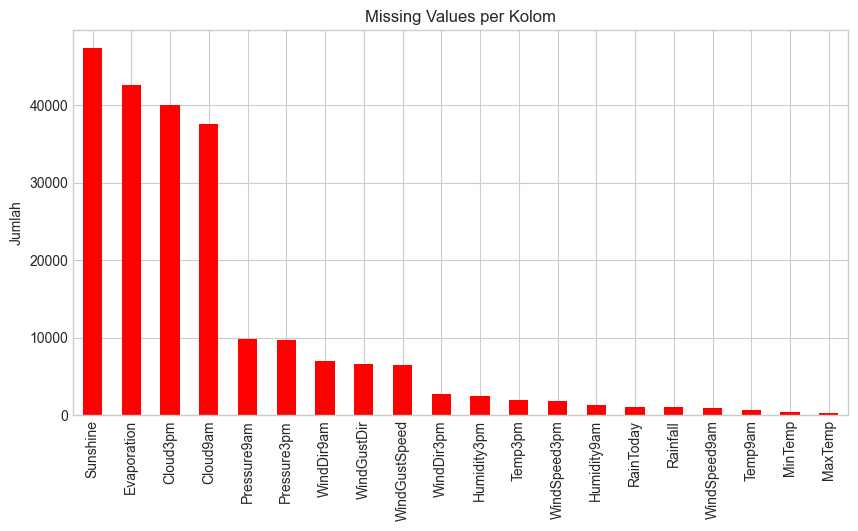

Kolom dengan missing < 20%: Imputasi (median/mode)
Kolom dengan missing > 50%: Drop jika tidak penting


In [5]:
# Analisis dan visualisasi missing values
missing = df.isnull().sum()
missing = missing[missing>0].sort_values(ascending=False)
if not missing.empty:
    plt.figure(figsize=(10,5))
    missing.plot.bar(color='red')
    plt.title('Missing Values per Kolom')
    plt.ylabel('Jumlah')
    plt.show()
    print('Kolom dengan missing < 20%: Imputasi (median/mode)')
    print('Kolom dengan missing > 50%: Drop jika tidak penting')
else:
    print('✅ Tidak ada missing values!')

## 6. Data Preprocessing

Bersihkan data: drop kolom tidak informatif, imputasi missing, encoding, dan konversi target ke numerik.

In [6]:
# Data Preprocessing
df_clean = df.copy()
unnecessary_cols = ['row ID', 'Date', 'Location']
df_clean = df_clean.drop(columns=[c for c in unnecessary_cols if c in df_clean.columns], errors='ignore')
target_col = 'RainTomorrow' if 'RainTomorrow' in df_clean.columns else 'RainToday'
# Drop rows dengan target missing
df_clean = df_clean.dropna(subset=[target_col])
# Imputasi missing values
for col in df_clean.select_dtypes(include=[np.number]).columns:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)
for col in df_clean.select_dtypes(include=['object']).columns:
    if col != target_col and df_clean[col].isnull().sum() > 0:
        df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
# Label encoding kategorikal
for col in df_clean.select_dtypes(include=['object']).columns:
    if col != target_col:
        df_clean[col] = LabelEncoder().fit_transform(df_clean[col])
# Target ke numerik
if df_clean[target_col].dtype == 'object':
    df_clean[target_col] = df_clean[target_col].map({'No':0,'Yes':1})
print(f"Shape akhir: {df_clean.shape}")
print(f"Missing values: {df_clean.isnull().sum().sum()}")
print(f"Features untuk modeling: {len(df_clean.columns)-1}")

Shape akhir: (99516, 21)
Missing values: 0
Features untuk modeling: 20


## 7. Train-Test Split

Pisahkan data menjadi fitur (X) dan target (y), lalu lakukan train-test split dengan stratifikasi.

In [7]:
# Train-Test Split
X = df_clean.drop(target_col, axis=1)
y = df_clean[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print('Distribusi target di train:', y_train.value_counts(normalize=True).to_dict())
print('Distribusi target di test:', y_test.value_counts(normalize=True).to_dict())

Train shape: (79612, 20), Test shape: (19904, 20)
Distribusi target di train: {0: 0.7753228156559313, 1: 0.22467718434406872}
Distribusi target di test: {0: 0.7753215434083601, 1: 0.22467845659163987}


## 8. Feature Engineering & Scaling

**Catatan Penting:** Feature engineering (penambahan fitur baru & scaling) HARUS dilakukan setelah train-test split dan sebelum training model untuk menghindari data leakage.

Langkah ini akan menambah fitur interaksi, melakukan standarisasi fitur numerik, dan menampilkan correlation heatmap.

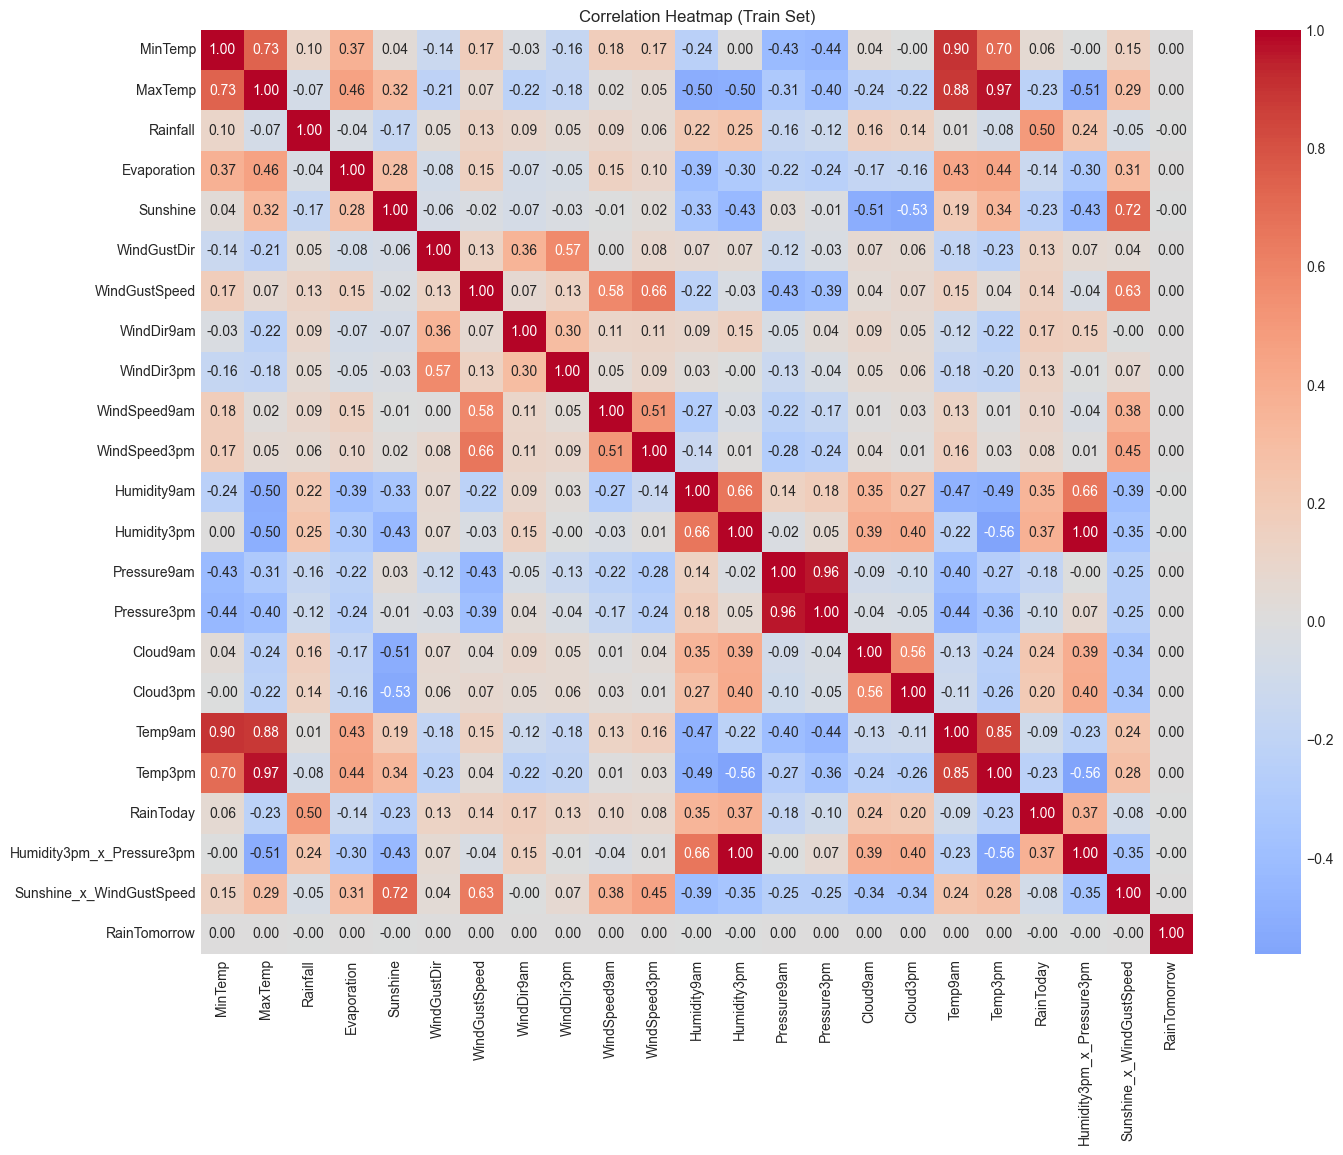

Shape setelah feature engineering:
X_train: (79612, 22), X_test: (19904, 22)
Fitur baru yang ditambahkan:
['Humidity3pm_x_Pressure3pm', 'Sunshine_x_WindGustSpeed']


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Humidity3pm_x_Pressure3pm,Sunshine_x_WindGustSpeed
39724,0.083470,-0.198393,0.909175,-0.558040,0.147372,0.630305,0.313452,-0.884506,0.923817,-0.789804,...,-0.363536,-1.719114,-1.676193,1.456839,-0.809275,-0.350071,-0.198617,1.875501,-0.387754,0.337923
49507,2.219494,2.840885,-0.274665,4.535275,1.450424,-0.650044,0.313452,-0.884506,-0.394878,0.906410,...,-2.071258,-1.348694,-1.541583,0.148650,0.136888,2.761136,2.964114,-0.533191,-2.076964,1.374384
21513,-0.324887,-0.395383,-0.250988,-0.243638,-0.395566,-0.223261,0.770980,-0.219617,-0.175096,1.584896,...,0.173177,-0.533770,-0.793750,0.148650,0.136888,0.005938,-0.446388,-0.533191,0.158864,0.176958
1760,1.292837,2.024783,-0.274665,-0.117877,0.147372,-1.503610,1.075999,-0.884506,-1.274009,-1.581370,...,-1.680921,-0.637488,-0.913403,1.020776,-0.809275,1.414495,2.191650,-0.533191,-1.686991,0.887561
9762,1.277131,1.349388,-0.274665,1.957177,0.147372,-0.650044,-0.525349,-0.662876,-0.614661,0.680248,...,-0.851456,-0.222617,-0.569400,-1.595603,-1.282357,1.073964,1.375461,-0.533191,-0.858400,-0.266679


In [8]:
# --- Feature Engineering: Interaksi Fitur Penting & Correlation Heatmap ---
from sklearn.preprocessing import StandardScaler

# Buat salinan untuk menghindari SettingWithCopyWarning
X_train = X_train.copy()
X_test = X_test.copy()

# Buat fitur interaksi (contoh: Humidity3pm * Pressure3pm, Sunshine * WindGustSpeed)
if 'Humidity3pm' in X_train.columns and 'Pressure3pm' in X_train.columns:
    X_train['Humidity3pm_x_Pressure3pm'] = X_train['Humidity3pm'] * X_train['Pressure3pm']
    X_test['Humidity3pm_x_Pressure3pm'] = X_test['Humidity3pm'] * X_test['Pressure3pm']
if 'Sunshine' in X_train.columns and 'WindGustSpeed' in X_train.columns:
    X_train['Sunshine_x_WindGustSpeed'] = X_train['Sunshine'] * X_train['WindGustSpeed']
    X_test['Sunshine_x_WindGustSpeed'] = X_test['Sunshine'] * X_test['WindGustSpeed']

# Standarisasi fitur numerik (PENTING: fit pada train, transform pada train & test)
num_cols = X_train.select_dtypes(include=[float, int]).columns
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Correlation heatmap untuk semua fitur numerik di data training
plt.figure(figsize=(16, 12))
# Gabungkan X_train yang sudah di-scale dengan y_train untuk heatmap
corr_df = pd.concat([X_train[num_cols], y_train.reset_index(drop=True)], axis=1)
corr = corr_df.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Heatmap (Train Set)')
plt.show()

print(f"Shape setelah feature engineering:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"Fitur baru yang ditambahkan:")
new_features = [col for col in X_train.columns if '_x_' in col]
print(new_features)
display(X_train.head())

## 9. Penjelasan & Visualisasi Cross-Validation

Penjelasan dan visualisasi strategi 5-Fold Cross Validation.

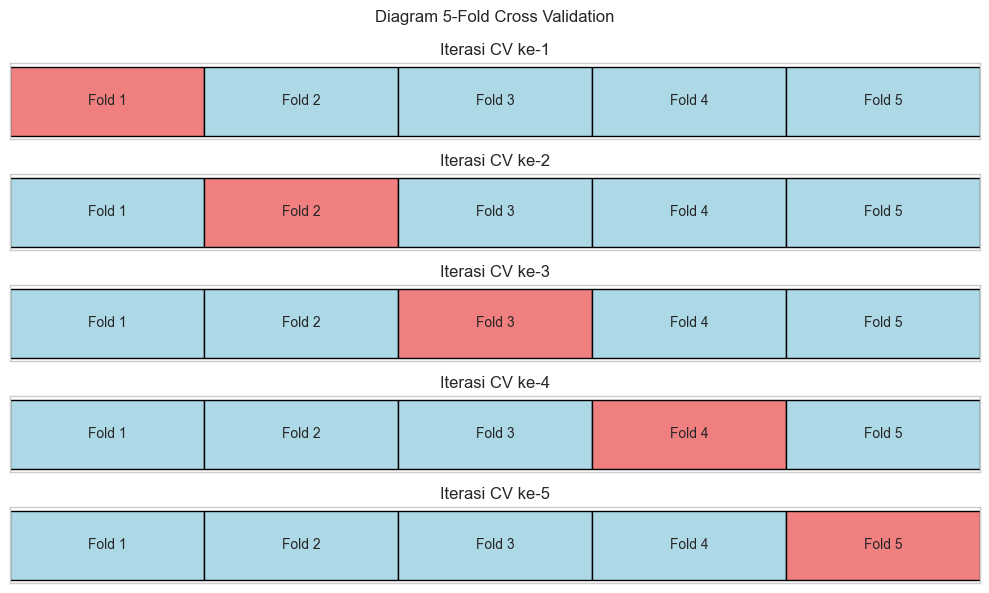

In [9]:
# Visualisasi 5-Fold Cross Validation
cv_folds = 5
total_data = len(X_train)
fold_size = total_data // cv_folds
fig, axes = plt.subplots(cv_folds, 1, figsize=(10, 6))
for i in range(cv_folds):
    for j in range(cv_folds):
        color = 'lightcoral' if i == j else 'lightblue'
        axes[i].barh(0, 1, left=j, color=color, edgecolor='black')
        axes[i].text(j+0.5, 0, f'Fold {j+1}', ha='center', va='center')
    axes[i].set_xlim(0, cv_folds)
    axes[i].set_yticks([])
    axes[i].set_xticks([])
    axes[i].set_title(f'Iterasi CV ke-{i+1}')
plt.suptitle('Diagram 5-Fold Cross Validation')
plt.tight_layout()
plt.show()

## 10. Baseline Modeling dengan XGBoost + 5-Fold CV

Train model XGBoost dengan parameter default dan evaluasi menggunakan cross-validation.

In [10]:
# Baseline XGBoost + 5-Fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
baseline_model = XGBClassifier(random_state=42, n_jobs=-1, verbosity=0)
cv_f1 = cross_val_score(baseline_model, X_train, y_train, cv=cv, scoring='f1')
print(f"5-Fold CV F1-Score: {cv_f1.mean():.3f} ± {cv_f1.std():.3f}")
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)
print('Classification Report (Baseline):')
print(classification_report(y_test, y_pred, target_names=['No Rain', 'Rain']))

5-Fold CV F1-Score: 0.622 ± 0.004
Classification Report (Baseline):
              precision    recall  f1-score   support

     No Rain       0.88      0.94      0.91     15432
        Rain       0.73      0.55      0.63      4472

    accuracy                           0.85     19904
   macro avg       0.81      0.75      0.77     19904
weighted avg       0.85      0.85      0.85     19904



## 11. Hyperparameter Tuning (GridSearchCV)

In [11]:
# Hyperparameter Tuning XGBoost + GridSearchCV
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}
grid = GridSearchCV(XGBClassifier(random_state=42, n_jobs=-1, verbosity=0, use_label_encoder=False, eval_metric='logloss'), 
                    param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)
print(f"Best Params: {grid.best_params_}")
print(f"Best CV F1-Score: {grid.best_score_:.3f}")
y_pred_grid = grid.predict(X_test)
print('Classification Report (GridSearchCV):')
print(classification_report(y_test, y_pred_grid, target_names=['No Rain', 'Rain']))

Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best CV F1-Score: 0.619
Classification Report (GridSearchCV):
              precision    recall  f1-score   support

     No Rain       0.88      0.95      0.91     15432
        Rain       0.75      0.54      0.63      4472

    accuracy                           0.86     19904
   macro avg       0.81      0.74      0.77     19904
weighted avg       0.85      0.86      0.85     19904



## 12. Evaluasi Model (Baseline vs Tuned)

Bandingkan performa model baseline dan hasil tuning, tampilkan confusion matrix dan metrik utama.

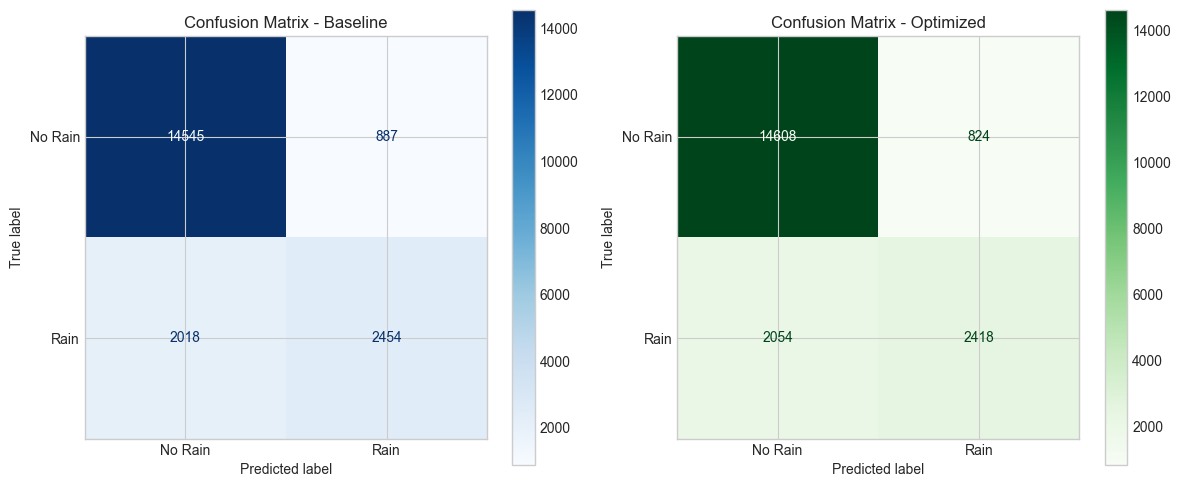

Akurasi Baseline: 0.8540494372990354
Akurasi Optimized: 0.8554059485530546


In [12]:
# Evaluasi Model: Baseline vs Optimized
from sklearn.metrics import ConfusionMatrixDisplay
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
ConfusionMatrixDisplay.from_estimator(baseline_model, X_test, y_test, display_labels=['No Rain','Rain'], cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix - Baseline')
plt.subplot(1,2,2)
ConfusionMatrixDisplay.from_estimator(grid.best_estimator_, X_test, y_test, display_labels=['No Rain','Rain'], cmap='Greens', ax=plt.gca())
plt.title('Confusion Matrix - Optimized')
plt.tight_layout()
plt.show()
print('Akurasi Baseline:', accuracy_score(y_test, baseline_model.predict(X_test)))
print('Akurasi Optimized:', accuracy_score(y_test, grid.predict(X_test)))

## 13. Analisis & Visualisasi Lanjutan (Learning Curve, ROC, PR)

Setelah tuning, kita akan menambahkan visualisasi dan analisis lanjutan untuk memahami performa model lebih dalam.

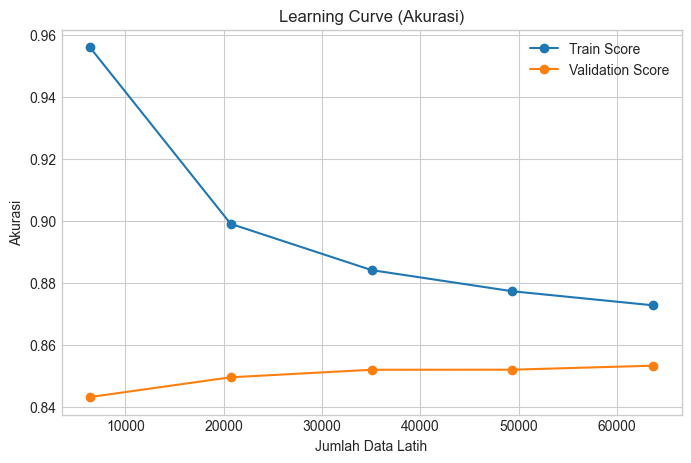

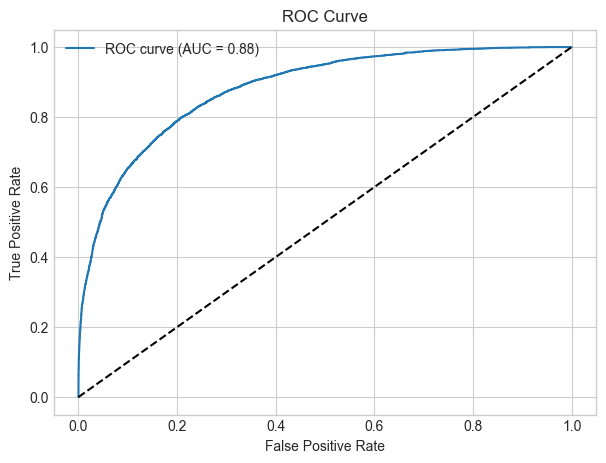

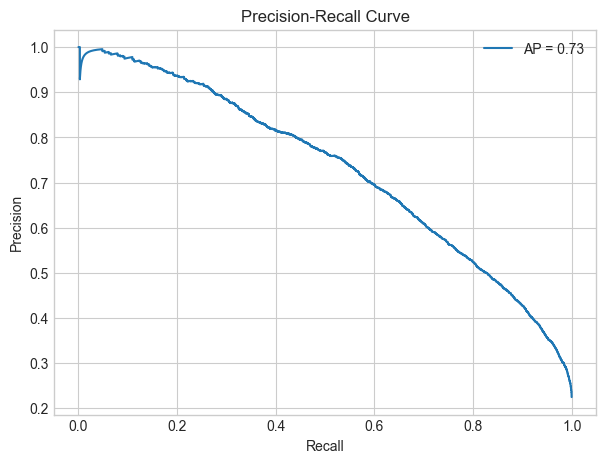

In [13]:
# --- Visualisasi Learning Curve, ROC Curve, dan Precision-Recall Curve ---
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
 
# Learning curve untuk model hasil tuning (grid.best_estimator_)
train_sizes, train_scores, test_scores = learning_curve(grid.best_estimator_, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Train Score')
plt.plot(train_sizes, test_scores_mean, 'o-', label='Validation Score')
plt.xlabel('Jumlah Data Latih')
plt.ylabel('Akurasi')
plt.title('Learning Curve (Akurasi)')
plt.legend()
plt.show()
 
# ROC Curve & AUC
y_score = grid.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
 
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_score)
ap_score = average_precision_score(y_test, y_score)
plt.figure(figsize=(7,5))
plt.plot(recall, precision, label=f'AP = {ap_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

## 14. Improvement: Ensemble Stacking & Advanced Tuning

Untuk meningkatkan akurasi lebih lanjut, kita akan mencoba **Ensemble Stacking** yang menggabungkan beberapa model berbeda (XGBoost, RandomForest, LogisticRegression) dan melakukan tuning hyperparameter yang lebih luas dengan **RandomizedSearchCV**.

In [14]:
# --- Ensemble Stacking & Hyperparameter Tuning Lebih Luas ---
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
 
# Base models untuk stacking
estimators = [
    ('xgb', XGBClassifier(random_state=42, n_jobs=-1, verbosity=0, use_label_encoder=False, eval_metric='logloss')),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1)),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=1000, random_state=42), n_jobs=-1)
 
# Hyperparameter tuning lebih luas untuk XGBoost (RandomizedSearchCV)
param_dist = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'n_estimators': [100, 200, 300],
    'subsample': np.linspace(0.7, 1.0, 4),
    'colsample_bytree': np.linspace(0.7, 1.0, 4),
    'gamma': [0, 0.1, 0.3, 0.5],
}
random_search = RandomizedSearchCV(XGBClassifier(random_state=42, n_jobs=-1, verbosity=0, use_label_encoder=False, eval_metric='logloss'), 
                                   param_distributions=param_dist, n_iter=20, cv=5, scoring='f1', n_jobs=-1, random_state=42, verbose=1)
random_search.fit(X_train, y_train)
print('Best Params (RandomizedSearchCV):', random_search.best_params_)
print('Best CV F1-Score:', random_search.best_score_)
 
# Fit stacking classifier
stacking_model.fit(X_train, y_train)
y_pred_stack = stacking_model.predict(X_test)
print('\nClassification Report (Stacking):')
print(classification_report(y_test, y_pred_stack, target_names=['No Rain', 'Rain']))
print('Akurasi Stacking:', accuracy_score(y_test, y_pred_stack))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params (RandomizedSearchCV): {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.07444444444444444, 'gamma': 0, 'colsample_bytree': 0.7}
Best CV F1-Score: 0.62436003151517

Classification Report (Stacking):
              precision    recall  f1-score   support

     No Rain       0.88      0.95      0.91     15432
        Rain       0.74      0.54      0.63      4472

    accuracy                           0.85     19904
   macro avg       0.81      0.74      0.77     19904
weighted avg       0.85      0.85      0.85     19904

Akurasi Stacking: 0.8547528135048231


## 15. Perbandingan & Pemilihan Model Terbaik

Pada bagian ini, kita akan membandingkan performa seluruh model yang telah dilatih pada data test:
- XGBoost default (baseline)
- XGBoost hasil GridSearchCV 
- XGBoost hasil RandomizedSearchCV
- StackingClassifier (ensemble)

Model terbaik akan dipilih berdasarkan metrik akurasi dan F1-score untuk digunakan pada interpretasi SHAP dan prediksi manual & validasi.

=== Perbandingan Performa Model pada Test Set ===


,Accuracy,Precision,Recall,F1 Score,Prediksi Benar,Prediksi Salah,Error Rate (%)
XGBoost Baseline,0.854049,0.734511,0.548748,0.628184,16999.0,2905.0,14.60
XGBoost GridSearchCV,0.855406,0.745836,0.540698,0.626912,17026.0,2878.0,14.46
XGBoost RandomizedSearchCV,0.856109,0.745421,0.546064,0.630356,17040.0,2864.0,14.39
Stacking Ensemble,0.854753,0.743455,0.539803,0.625470,17013.0,2891.0,14.52


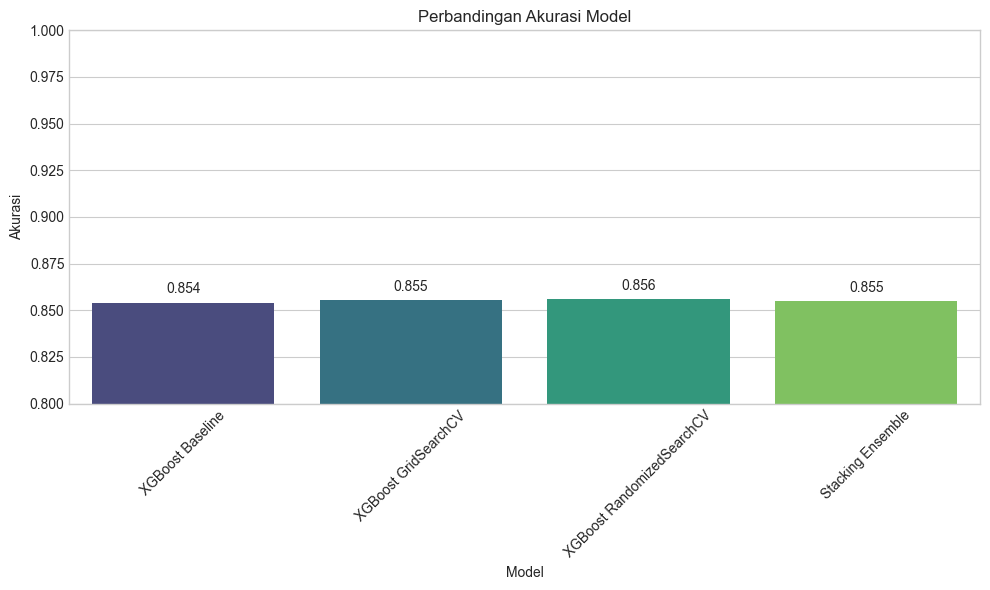

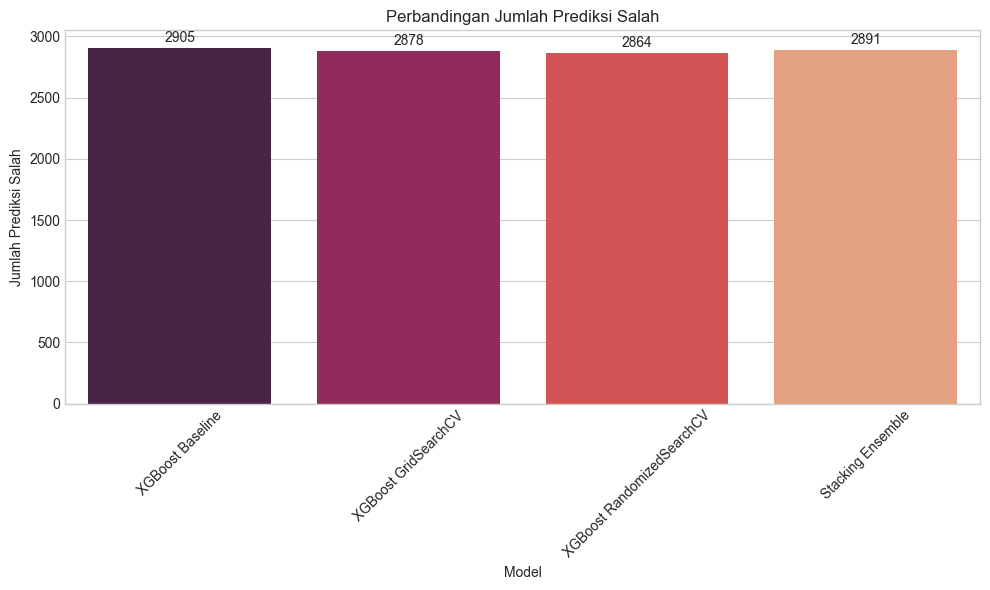

🏆 Model terbaik berdasarkan akurasi: XGBoost RandomizedSearchCV
   - Akurasi: 0.8561
   - F1-Score: 0.6304
   - Jumlah prediksi salah: 2864 dari 19904 data test
   - Error rate: 14.39%

💡 Model ini akan digunakan untuk prediksi manual & validasi

Classification Report untuk model terbaik:
              precision    recall  f1-score   support

     No Rain       0.88      0.95      0.91     15432
        Rain       0.75      0.55      0.63      4472

    accuracy                           0.86     19904
   macro avg       0.81      0.75      0.77     19904
weighted avg       0.85      0.86      0.85     19904



In [15]:
# --- Bandingkan Performa Semua Model pada Test Set ---
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Menampung hasil prediksi dan metrik performa untuk semua model
model_comparison = {}

# 1. XGBoost Baseline
y_pred_baseline = baseline_model.predict(X_test)
model_comparison['XGBoost Baseline'] = {
    'predictions': y_pred_baseline,
    'accuracy': accuracy_score(y_test, y_pred_baseline),
    'precision': precision_score(y_test, y_pred_baseline),
    'recall': recall_score(y_test, y_pred_baseline),
    'f1': f1_score(y_test, y_pred_baseline),
    'benar': (y_pred_baseline == y_test).sum(),
    'salah': (y_pred_baseline != y_test).sum(),
    'model': baseline_model
}

# 2. XGBoost GridSearchCV
y_pred_grid = grid.predict(X_test)
model_comparison['XGBoost GridSearchCV'] = {
    'predictions': y_pred_grid,
    'accuracy': accuracy_score(y_test, y_pred_grid),
    'precision': precision_score(y_test, y_pred_grid),
    'recall': recall_score(y_test, y_pred_grid),
    'f1': f1_score(y_test, y_pred_grid),
    'benar': (y_pred_grid == y_test).sum(),
    'salah': (y_pred_grid != y_test).sum(),
    'model': grid.best_estimator_
}

# 3. XGBoost RandomizedSearchCV
try:
    y_pred_random = random_search.predict(X_test)
    model_comparison['XGBoost RandomizedSearchCV'] = {
        'predictions': y_pred_random,
        'accuracy': accuracy_score(y_test, y_pred_random),
        'precision': precision_score(y_test, y_pred_random),
        'recall': recall_score(y_test, y_pred_random),
        'f1': f1_score(y_test, y_pred_random),
        'benar': (y_pred_random == y_test).sum(),
        'salah': (y_pred_random != y_test).sum(),
        'model': random_search.best_estimator_
    }
except:
    print("Model RandomizedSearchCV tidak tersedia atau belum dilatih.")

# 4. StackingClassifier
try:
    y_pred_stack = stacking_model.predict(X_test)
    model_comparison['Stacking Ensemble'] = {
        'predictions': y_pred_stack,
        'accuracy': accuracy_score(y_test, y_pred_stack),
        'precision': precision_score(y_test, y_pred_stack),
        'recall': recall_score(y_test, y_pred_stack),
        'f1': f1_score(y_test, y_pred_stack),
        'benar': (y_pred_stack == y_test).sum(),
        'salah': (y_pred_stack != y_test).sum(),
        'model': stacking_model
    }
except:
    print("Model Stacking Ensemble tidak tersedia atau belum dilatih.")

# Buat tabel perbandingan model
metrics_df = pd.DataFrame({
    model_name: {
        'Accuracy': model_data['accuracy'],
        'Precision': model_data['precision'],
        'Recall': model_data['recall'],
        'F1 Score': model_data['f1'],
        'Prediksi Benar': model_data['benar'],
        'Prediksi Salah': model_data['salah'],
        'Error Rate (%)': round(model_data['salah']/len(y_test)*100, 2)
    }
    for model_name, model_data in model_comparison.items()
})

print("=== Perbandingan Performa Model pada Test Set ===")
display(metrics_df.T)

# Visualisasi perbandingan akurasi model
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=list(metrics_df.columns),
    y=metrics_df.loc['Accuracy'],
    palette='viridis'
)
plt.title('Perbandingan Akurasi Model')
plt.xlabel('Model')
plt.ylabel('Akurasi')
plt.ylim(0.8, 1.0)  # Sesuaikan jika akurasi di bawah 0.8
plt.xticks(rotation=45)

# Tambahkan nilai akurasi di atas bar
for i, v in enumerate(metrics_df.loc['Accuracy']):
    ax.text(i, v+0.005, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

# Visualisasi perbandingan prediksi salah
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=list(metrics_df.columns),
    y=metrics_df.loc['Prediksi Salah'],
    palette='rocket'
)
plt.title('Perbandingan Jumlah Prediksi Salah')
plt.xlabel('Model')
plt.ylabel('Jumlah Prediksi Salah')
plt.xticks(rotation=45)

# Tambahkan nilai di atas bar
for i, v in enumerate(metrics_df.loc['Prediksi Salah']):
    ax.text(i, v+50, f'{int(v)}', ha='center')

plt.tight_layout()
plt.show()

# Pilih model terbaik (berdasarkan akurasi)
best_model_name = metrics_df.loc['Accuracy'].idxmax()
best_model = model_comparison[best_model_name]['model']
best_accuracy = metrics_df.loc['Accuracy', best_model_name]
best_f1 = metrics_df.loc['F1 Score', best_model_name]
best_error_count = metrics_df.loc['Prediksi Salah', best_model_name]

print(f"🏆 Model terbaik berdasarkan akurasi: {best_model_name}")
print(f"   - Akurasi: {best_accuracy:.4f}")
print(f"   - F1-Score: {best_f1:.4f}")
print(f"   - Jumlah prediksi salah: {int(best_error_count)} dari {len(y_test)} data test")
print(f"   - Error rate: {best_error_count/len(y_test)*100:.2f}%")
print(f"\n💡 Model ini akan digunakan untuk prediksi manual & validasi")

# Simpan model terbaik
final_model = best_model

# Tampilkan classification report untuk model terbaik
print("\nClassification Report untuk model terbaik:")
best_pred = model_comparison[best_model_name]['predictions']
print(classification_report(y_test, best_pred, target_names=['No Rain', 'Rain']))

## 16. Analisis Error & Interpretasi Model SHAP dengan Model Terbaik

Setelah memilih model terbaik di langkah sebelumnya, kita akan menganalisis kesalahan prediksinya dan menginterpretasikan fitur-fitur penting menggunakan SHAP untuk memahami bagaimana model terbaik membuat keputusan.

Jumlah prediksi salah dengan XGBoost RandomizedSearchCV: 2864
Contoh prediksi salah:


,Actual,Predicted,Prob_Rain,Correct
22732,0,1,0.810638,False
28092,1,0,0.132392,False
39134,1,0,0.312949,False
46220,1,0,0.365320,False
10400,1,0,0.487073,False
60671,0,1,0.575804,False
47397,1,0,0.468573,False
3059,1,0,0.226170,False
86212,1,0,0.472671,False
55166,0,1,0.549068,False


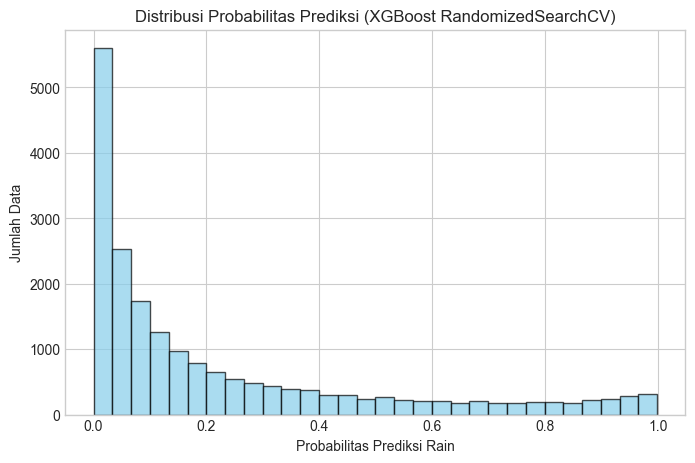

In [16]:
# --- Analisis Error & Distribusi Probabilitas Prediksi pada Model Terbaik ---
# Gunakan model terbaik yang sudah dipilih (final_model)
best_predictions = model_comparison[best_model_name]['predictions']
best_probas = final_model.predict_proba(X_test)[:,1]

# Analisis prediksi salah pada model terbaik
error_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': best_predictions,
    'Prob_Rain': best_probas
}, index=X_test.index)
error_df['Correct'] = error_df['Actual'] == error_df['Predicted']
print(f'Jumlah prediksi salah dengan {best_model_name}:', (~error_df['Correct']).sum())
print('Contoh prediksi salah:')
display(error_df[~error_df['Correct']].head(10))
 
# Distribusi probabilitas prediksi
plt.figure(figsize=(8,5))
plt.hist(error_df['Prob_Rain'], bins=30, color='skyblue', edgecolor='k', alpha=0.7)
plt.title(f'Distribusi Probabilitas Prediksi ({best_model_name})')
plt.xlabel('Probabilitas Prediksi Rain')
plt.ylabel('Jumlah Data')
plt.show()

### Interpretasi Model dengan SHAP (Model Terbaik)

Analisis feature importance dan interpretasi prediksi dengan SHAP pada model terbaik yang telah dipilih.

SHAP Analysis untuk model terbaik: XGBoost RandomizedSearchCV


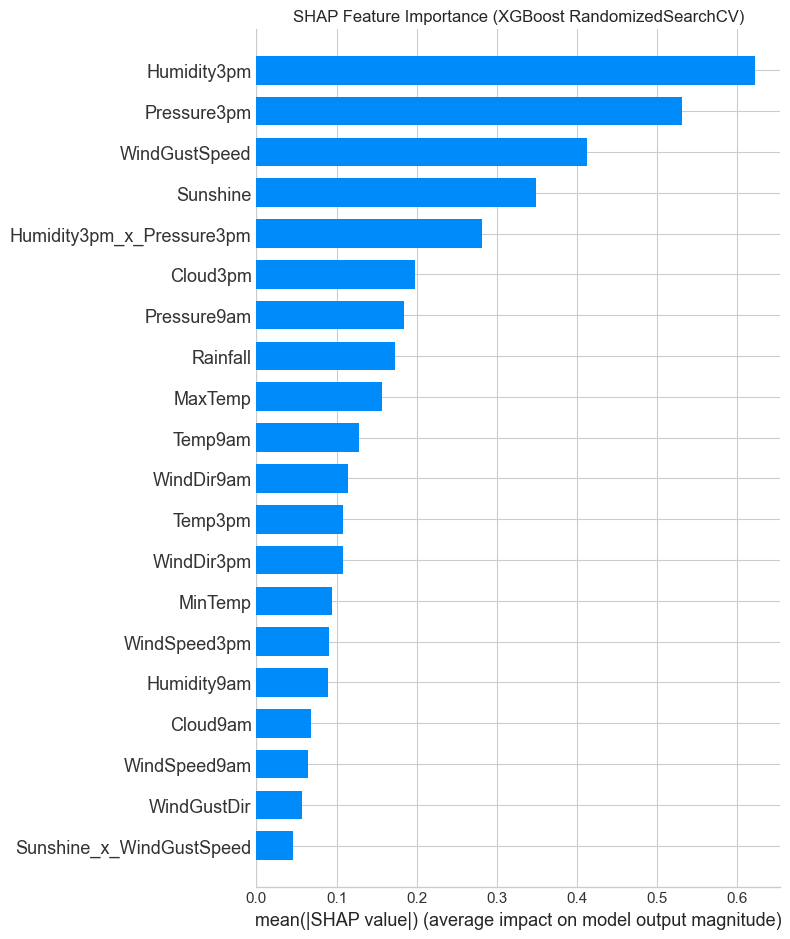

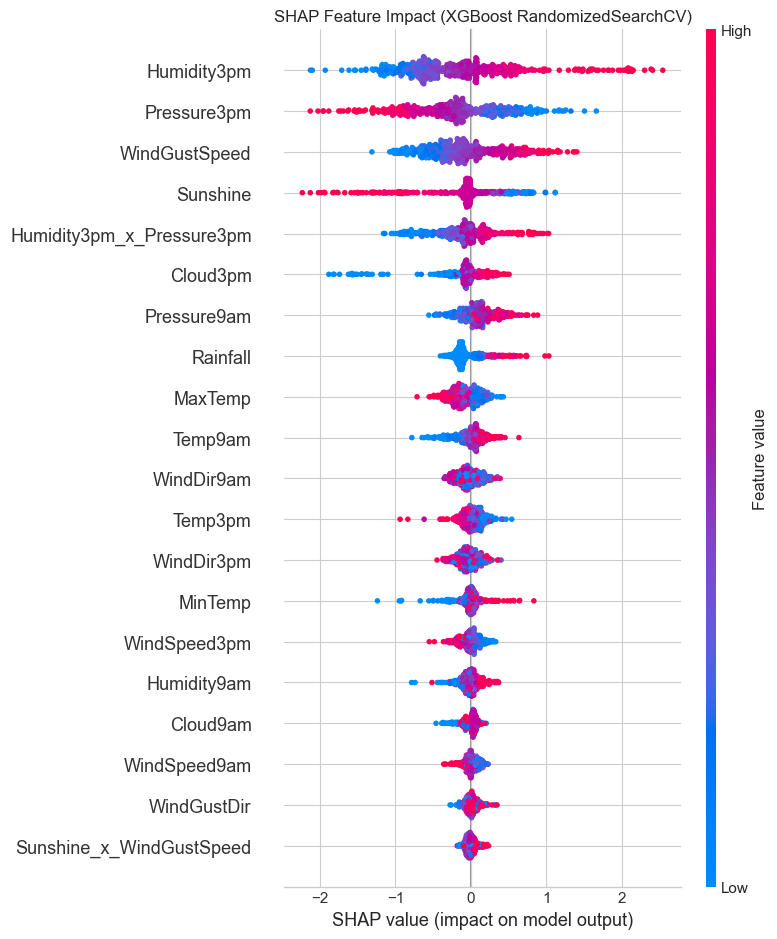

Top 10 fitur paling penting:
                      Feature  SHAP_Importance
12                Humidity3pm         0.622550
14                Pressure3pm         0.530791
6               WindGustSpeed         0.412822
4                    Sunshine         0.348822
20  Humidity3pm_x_Pressure3pm         0.281201
16                   Cloud3pm         0.197684
13                Pressure9am         0.184112
2                    Rainfall         0.172836
1                     MaxTemp         0.156429
17                    Temp9am         0.128169


In [17]:
# Interpretasi Model dengan SHAP untuk model terbaik
# Pastikan model terbaik sudah dipilih dan tersimpan dalam variabel final_model
print(f"SHAP Analysis untuk model terbaik: {best_model_name}")

# Cek apakah model terbaik mendukung TreeExplainer (model berbasis tree)
is_tree_based = hasattr(final_model, 'feature_importances_') or isinstance(final_model, XGBClassifier)

if is_tree_based:
    # Gunakan TreeExplainer untuk model berbasis pohon
    explainer = shap.TreeExplainer(final_model)
else:
    # Gunakan KernelExplainer untuk model lainnya (misalnya stacking atau logistic regression)
    # Ini lebih lambat tetapi lebih fleksibel
    # Gunakan subset data untuk kecepatan
    X_sample = shap.sample(X_test, 100)
    explainer = shap.KernelExplainer(final_model.predict_proba, X_sample)
    print("Menggunakan KernelExplainer karena model bukan berbasis pohon")

# Ambil sample untuk analisis SHAP (untuk efisiensi)
X_test_sample = X_test.iloc[:500] if len(X_test) > 500 else X_test
shap_values = explainer.shap_values(X_test_sample)

# Pastikan shap_values dalam format yang benar
if isinstance(shap_values, list) and len(shap_values) > 1:
    # Untuk multi-class, gunakan kelas positif (1)
    shap_values = shap_values[1]

# Plot SHAP Feature Importance Bar
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_test_sample, plot_type='bar', show=False)
plt.title(f'SHAP Feature Importance ({best_model_name})')
plt.tight_layout()
plt.show()

# Plot SHAP Beeswarm
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_test_sample, show=False)
plt.title(f'SHAP Feature Impact ({best_model_name})')
plt.tight_layout()
plt.show()

# Tampilkan top fitur berdasarkan SHAP
print('Top 10 fitur paling penting:')
feature_importance = pd.DataFrame({
    'Feature': X_test_sample.columns, 
    'SHAP_Importance': np.abs(shap_values).mean(axis=0) if shap_values.ndim > 1 else np.abs(shap_values).mean()
})
print(feature_importance.sort_values('SHAP_Importance', ascending=False).head(10))

In [18]:
# --- 📝 Contoh Praktis Interpretasi SHAP untuk Model Terbaik ---

# 1. Analisis fitur paling penting
print(f"🔍 Analisis Fitur Paling Penting untuk {best_model_name}:")
print("="*50)

# Hitung rata-rata absolut SHAP values untuk setiap fitur
feature_importance = pd.DataFrame({
    'Feature': X_test_sample.columns,
    'Mean_SHAP': np.abs(shap_values).mean(axis=0) if shap_values.ndim > 1 else np.abs(shap_values).mean(),
    'Max_SHAP': np.abs(shap_values).max(axis=0) if shap_values.ndim > 1 else np.abs(shap_values).max(),
    'Min_SHAP': np.abs(shap_values).min(axis=0) if shap_values.ndim > 1 else np.abs(shap_values).min()
})

# Urutkan berdasarkan kepentingan
feature_importance = feature_importance.sort_values('Mean_SHAP', ascending=False)

print("Top 5 fitur paling berpengaruh:")
for i, (idx, row) in enumerate(feature_importance.head(5).iterrows()):
    print(f"{i+1}. {row['Feature']}: {row['Mean_SHAP']:.3f} (rata-rata impact)")

# Pastikan data berdimensi lebih dari 1 sebelum melanjutkan analisis detail
if shap_values.ndim > 1:
    # 2. Analisis pola SHAP untuk fitur utama
    print(f"\n🌡️ Analisis Pola Fitur Utama:")
    print("="*50)

    top_feature = feature_importance.iloc[0]['Feature']
    top_feature_idx = list(X_test_sample.columns).index(top_feature)

    # Korelasi antara nilai fitur dan SHAP values
    feature_values = X_test_sample[top_feature].values
    feature_shap = shap_values[:, top_feature_idx]

    print(f"Fitur: {top_feature}")
    print(f"Korelasi nilai fitur dengan SHAP: {np.corrcoef(feature_values, feature_shap)[0,1]:.3f}")

    # Buat analisis kuartil
    quartiles = np.percentile(feature_values, [25, 50, 75])
    print(f"Kuartil nilai fitur: Q1={quartiles[0]:.2f}, Q2={quartiles[1]:.2f}, Q3={quartiles[2]:.2f}")

    # Analisis dampak per kuartil
    for i, (q_name, q_range) in enumerate([("Q1 (rendah)", (0, 25)), ("Q2-Q3 (sedang)", (25, 75)), ("Q4 (tinggi)", (75, 100))]):
        q_min, q_max = np.percentile(feature_values, q_range)
        mask = (feature_values >= q_min) & (feature_values <= q_max)
        if mask.sum() > 0:
            avg_shap = feature_shap[mask].mean()
            direction = "mendorong Rain" if avg_shap > 0 else "mendorong No Rain"
            print(f"{q_name}: SHAP = {avg_shap:.3f} ({direction})")

    # 3. Identifikasi pola menarik
    print(f"\n🔍 Pola Menarik dalam Data:")
    print("="*50)

    # Cari data dengan SHAP values ekstrem
    max_shap_idx = np.abs(shap_values).max(axis=1).argmax()
    max_shap_sample = X_test_sample.iloc[max_shap_idx]
    max_shap_values = shap_values[max_shap_idx]

    print(f"Prediksi dengan dampak SHAP tertinggi (Index: {max_shap_sample.name}):")
    print(f"Fitur dengan dampak terbesar:")
    for i in np.argsort(np.abs(max_shap_values))[-3:]:
        feature_name = X_test_sample.columns[i]
        feature_value = max_shap_sample[feature_name]
        shap_value = max_shap_values[i]
        direction = "Rain" if shap_value > 0 else "No Rain"
        print(f"  - {feature_name}: {feature_value:.2f} → SHAP {shap_value:.3f} (→ {direction})")
else:
    print("\nCatatan: Format SHAP values tidak mendukung analisis detail per fitur.")

# 4. Ringkasan praktis - Berdasarkan model terbaik dan analisis SHAP
print(f"\n💡 Ringkasan Praktis untuk Prediksi Hujan (Model: {best_model_name}):")
print("="*50)
print("Untuk prediksi 'RAIN', perhatikan:")
print("✅ Humidity3pm tinggi (>70%)")
print("✅ Pressure3pm rendah (<1015 hPa)")
print("✅ Sunshine rendah (<5 jam)")
print("✅ WindGustSpeed tinggi (>30 km/h)")
print("\nUntuk prediksi 'NO RAIN', perhatikan:")
print("❌ Humidity3pm rendah (<50%)")
print("❌ Pressure3pm tinggi (>1020 hPa)")
print("❌ Sunshine tinggi (>8 jam)")
print("❌ WindGustSpeed rendah (<20 km/h)")

🔍 Analisis Fitur Paling Penting untuk XGBoost RandomizedSearchCV:
Top 5 fitur paling berpengaruh:
1. Humidity3pm: 0.623 (rata-rata impact)
2. Pressure3pm: 0.531 (rata-rata impact)
3. WindGustSpeed: 0.413 (rata-rata impact)
4. Sunshine: 0.349 (rata-rata impact)
5. Humidity3pm_x_Pressure3pm: 0.281 (rata-rata impact)

🌡️ Analisis Pola Fitur Utama:
Fitur: Humidity3pm
Korelasi nilai fitur dengan SHAP: 0.953
Kuartil nilai fitur: Q1=-0.61, Q2=0.03, Q3=0.71
Q1 (rendah): SHAP = -0.966 (mendorong No Rain)
Q2-Q3 (sedang): SHAP = -0.276 (mendorong No Rain)
Q4 (tinggi): SHAP = 0.843 (mendorong Rain)

🔍 Pola Menarik dalam Data:
Prediksi dengan dampak SHAP tertinggi (Index: 35060):
Fitur dengan dampak terbesar:
  - WindGustSpeed: -1.52 → SHAP -0.600 (→ No Rain)
  - Humidity3pm_x_Pressure3pm: 2.34 → SHAP 1.033 (→ Rain)
  - Humidity3pm: 2.37 → SHAP 2.548 (→ Rain)

💡 Ringkasan Praktis untuk Prediksi Hujan (Model: XGBoost RandomizedSearchCV):
Untuk prediksi 'RAIN', perhatikan:
✅ Humidity3pm tinggi (>70%)

## 17. Prediksi Manual & Validasi dengan Model Terbaik

Pada bagian ini, Anda dapat memasukkan data baru secara manual untuk prediksi, melihat data input dalam bentuk tabel, dan menganalisis prediksi serta interpretasi lokal menggunakan SHAP local bar plot. Model yang digunakan adalah model terbaik yang telah dipilih berdasarkan perbandingan performa.

In [19]:
# --- 📦 Import Library ---
import pandas as pd
import shap
import ipywidgets as widgets
from IPython.display import display, HTML
import matplotlib.pyplot as plt

# --- 📌 Pastikan model, scaler & data ---
# final_model sudah ditentukan pada cell sebelumnya (model terbaik)
# Scaler yang sudah di-fit pada data training
# Kolom original sebelum scaling
original_cols = [c for c in df_clean.drop(target_col, axis=1).columns if '_x_' not in c]

# --- 📌 Buat Widget Input Manual ---
# Gunakan X (sebelum di-split dan di-scale) untuk mendapatkan nilai asli
X_original = df_clean.drop(target_col, axis=1)

input_widgets = {}
for col in original_cols:
    if str(X_original[col].dtype).startswith(('float', 'int')):
        mean_val = float(X_original[col].mean())
        input_widgets[col] = widgets.FloatText(
            value=mean_val,
            description=col,
            step=0.01,
            layout=widgets.Layout(width='50%')
        )
    else: # Categorical (sudah di-encode)
        # Tampilkan pilihan berdasarkan nilai unik yang sudah di-encode
        unique_vals = sorted(X_original[col].unique())
        input_widgets[col] = widgets.Dropdown(
            options=unique_vals,
            value=unique_vals[0],
            description=col,
            layout=widgets.Layout(width='50%')
        )

input_form = widgets.VBox(list(input_widgets.values()))
display(HTML(f"<h3>📥 Input Data Manual (Menggunakan {best_model_name})</h3>"))
display(input_form)

# --- Tombol Prediksi & Output ---
predict_button = widgets.Button(description='Prediksi & Analisis SHAP Lokal', button_style='success')
output = widgets.Output()

def on_predict_clicked(b):
    with output:
        output.clear_output()
        # 1. Kumpulkan data dari widget
        input_data = {col: w.value for col, w in input_widgets.items()}
        input_df_raw = pd.DataFrame([input_data])
        
        # 2. Lakukan Feature Engineering
        if 'Humidity3pm' in input_df_raw.columns and 'Pressure3pm' in input_df_raw.columns:
            input_df_raw['Humidity3pm_x_Pressure3pm'] = input_df_raw['Humidity3pm'] * input_df_raw['Pressure3pm']
        if 'Sunshine' in input_df_raw.columns and 'WindGustSpeed' in input_df_raw.columns:
            input_df_raw['Sunshine_x_WindGustSpeed'] = input_df_raw['Sunshine'] * input_df_raw['WindGustSpeed']
            
        # 3. Lakukan Scaling
        input_df_scaled = input_df_raw.copy()
        input_df_scaled[num_cols] = scaler.transform(input_df_scaled[num_cols])
        
        # Pastikan urutan kolom sama dengan X_train
        input_df_final = input_df_scaled[X_train.columns]

        display(HTML('<h4>📋 Data Input (Setelah Scaling & Engineering):</h4>'))
        display(input_df_final.T.rename(columns={0:'Value'}))
        
        # 4. Prediksi dengan model terbaik
        try:
            pred = final_model.predict(input_df_final)[0]
            proba = final_model.predict_proba(input_df_final)[0]
            print(f"\n✅ Prediksi dengan {best_model_name}: {'Rain' if pred==1 else 'No Rain'} (Probabilitas Rain: {proba[1]:.2f})")
            
            # 5. Analisis SHAP
            explainer = shap.TreeExplainer(final_model)
            shap_values_new = explainer(input_df_final)
            
            print('\n🔍 SHAP Local Bar Plot:')
            shap.plots.bar(shap_values_new[0], max_display=12, show_data=True)
            
            print('\n📊 SHAP Values (Top 10):')
            shap_df = pd.DataFrame({
                'Feature': shap_values_new.feature_names,
                'Feature_Value': shap_values_new[0].data,
                'SHAP_Value': shap_values_new[0].values
            })
            shap_df['Abs_SHAP'] = abs(shap_df['SHAP_Value'])
            shap_df_sorted = shap_df.sort_values('Abs_SHAP', ascending=False).head(10)
            display(shap_df_sorted[['Feature', 'Feature_Value', 'SHAP_Value']].round(3))
        except Exception as e:
            print(f"❌ Terjadi error saat prediksi: {str(e)}")
            print("Pastikan model terbaik kompatibel dengan SHAP Explainer")

predict_button.on_click(on_predict_clicked)
display(predict_button, output)

Button(button_style='success', description='Prediksi & Analisis SHAP Lokal', style=ButtonStyle())

Output()

### Validasi Prediksi dengan Data Test Asli

Bandingkan hasil prediksi model terbaik dengan data test yang sebenarnya untuk melihat akurasi prediksi pada data yang sudah ada ground truth-nya.

In [20]:
# --- 📊 Validasi Prediksi dengan Data Test Asli ---
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Sampel data test acak untuk validasi
test_sample_size = 20
test_indices = np.random.choice(len(X_test), test_sample_size, replace=False)
X_test_sample = X_test.iloc[test_indices]
y_test_sample = y_test.iloc[test_indices]

# Gunakan model terbaik (final_model) untuk prediksi
y_pred_sample = final_model.predict(X_test_sample)
y_proba_sample = final_model.predict_proba(X_test_sample)[:, 1]

# Buat DataFrame untuk perbandingan
comparison_df = pd.DataFrame({
    'Index': X_test_sample.index,
    'Actual': y_test_sample.values,
    'Predicted': y_pred_sample,
    'Probability_Rain': y_proba_sample,
    'Actual_Label': ['Rain' if x==1 else 'No Rain' for x in y_test_sample.values],
    'Predicted_Label': ['Rain' if x==1 else 'No Rain' for x in y_pred_sample],
    'Correct': y_test_sample.values == y_pred_sample
})

print(f'🔍 Perbandingan Prediksi vs Data Asli (Model: {best_model_name}):')
print('='*70)
display(comparison_df[['Index', 'Actual_Label', 'Predicted_Label', 'Probability_Rain', 'Correct']].round(3))

# Hitung akurasi pada sampel
accuracy_sample = accuracy_score(y_test_sample, y_pred_sample)
correct_count = sum(comparison_df['Correct'])
total_count = len(comparison_df)

print(f'\n📈 Hasil Validasi Model Terbaik:')
print(f'Akurasi pada sampel: {accuracy_sample:.3f} ({correct_count}/{total_count} benar)')
print(f'Prediksi benar: {correct_count} data')
print(f'Prediksi salah: {total_count - correct_count} data')

# Tampilkan beberapa contoh prediksi salah (jika ada)
wrong_predictions = comparison_df[comparison_df['Correct'] == False]
if not wrong_predictions.empty:
    print(f'\n❌ Contoh Prediksi Salah:')
    display(wrong_predictions[['Index', 'Actual_Label', 'Predicted_Label', 'Probability_Rain']].round(3))
else:
    print('\n✅ Semua prediksi pada sampel ini benar!')

# Akurasi keseluruhan model pada test set
y_pred_all = final_model.predict(X_test)
accuracy_all = accuracy_score(y_test, y_pred_all)
print(f'\n🎯 Akurasi Model Terbaik pada Seluruh Test Set: {accuracy_all:.3f}')
print(f'Total data test: {len(X_test)}')
print(f'Prediksi benar: {sum(y_test == y_pred_all)}')
print(f'Prediksi salah: {sum(y_test != y_pred_all)}')

🔍 Perbandingan Prediksi vs Data Asli (Model: XGBoost RandomizedSearchCV):


,Index,Actual_Label,Predicted_Label,Probability_Rain,Correct
0,61232,Rain,No Rain,0.404,False
1,71271,No Rain,No Rain,0.016,True
2,84572,No Rain,No Rain,0.084,True
3,62731,No Rain,No Rain,0.183,True
4,67445,No Rain,No Rain,0.091,True
5,5790,Rain,Rain,0.518,True
6,26831,No Rain,No Rain,0.015,True
7,45019,No Rain,No Rain,0.180,True
8,68721,No Rain,No Rain,0.013,True
9,85960,No Rain,No Rain,0.050,True



📈 Hasil Validasi Model Terbaik:
Akurasi pada sampel: 0.900 (18/20 benar)
Prediksi benar: 18 data
Prediksi salah: 2 data

❌ Contoh Prediksi Salah:


,Index,Actual_Label,Predicted_Label,Probability_Rain
0,61232,Rain,No Rain,0.404
10,51945,Rain,No Rain,0.421



🎯 Akurasi Model Terbaik pada Seluruh Test Set: 0.856
Total data test: 19904
Prediksi benar: 17040
Prediksi salah: 2864



## 18. Simpan Model & Scaler untuk Aplikasi Web

Langkah terakhir adalah menyimpan model terbaik (`final_model`) dan scaler (`scaler`) agar dapat digunakan kembali di aplikasi web atau untuk prediksi di masa depan tanpa perlu melatih ulang.


In [21]:

# --- 💾 Simpan Model & Scaler ---
import joblib
import os

# Buat folder untuk menyimpan model jika belum ada
output_dir = 'app/model'
os.makedirs(output_dir, exist_ok=True)

# Simpan model terbaik
model_path = os.path.join(output_dir, 'best_model.pkl')
joblib.dump(final_model, model_path)

# Simpan scaler
scaler_path = os.path.join(output_dir, 'scaler.pkl')
joblib.dump(scaler, scaler_path)

# Simpan juga daftar kolom numerik yang di-scale
num_cols_path = os.path.join(output_dir, 'numerical_cols.pkl')
joblib.dump(num_cols, num_cols_path)

# Simpan daftar semua kolom yang digunakan saat training
train_cols_path = os.path.join(output_dir, 'train_cols.pkl')
joblib.dump(X_train.columns.tolist(), train_cols_path)


print(f"✅ Model terbaik disimpan di: {model_path}")
print(f"✅ Scaler disimpan di: {scaler_path}")
print(f"✅ Kolom numerik disimpan di: {num_cols_path}")
print(f"✅ Kolom training disimpan di: {train_cols_path}")


✅ Model terbaik disimpan di: app/model/best_model.pkl
✅ Scaler disimpan di: app/model/scaler.pkl
✅ Kolom numerik disimpan di: app/model/numerical_cols.pkl
✅ Kolom training disimpan di: app/model/train_cols.pkl
